# Quickstart - Monitoring Water Quality in the Mississippi Sound using Harmonized Landsat Sentinel-2 (HLS) Data
---
This notebook deomnstrates how to use `pcxarray` to query and prepare a timeseries of HLS data that is suitable for monitoring water turbidity trends in the Mississippi Sound.

## First - defining a region of interest
A geometry denoting the region of interest (ROI) is required to both query against the Planetary Computer data catalog and to facilitate the preparation of the imagery. **The CRS of the geometry is important, as all results from `pcxarray` will be returned in the same CRS as the geometry (and reprojected if necessary).** By default, `pcxarray` assumes any geometry it receives for any query or preparation operation is in WGS84 (EPSG:4326). Naturally, using a geographic CRS is often suboptimal for most applications, so it is highly recommended to transform a given ROI geometry to an appropriate projected CRS before using it with `pcxarray`.

In this example, a rectangular geometry over the Mississippi Sound region in the northern Gulf Coast of the United States is used. Once the geometry is defined, it will be added to a GeoPandas GeoDataFrame, which will enable quick and easy projection to UTM 16N and visualization of the ROI later. Technically, a GeoDataFrame is not required, but it makes certain reprojection and plotting tasks easier.

*NOTE: While the geometry is technically horizontal in its native Geographic CRS, it will be angled slightly in the projected CRS. Applying `.envelope` on the geometry will return another rectangular geometry that encompasses the original geometry without any rotation in the projected CRS. Usage of this envelope geometry is not required, but is used in this example to prevent the ROI from appearing rotated in the projected CRS.*

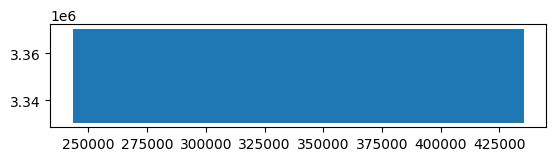

In [1]:
from shapely.geometry import Polygon
import geopandas as gpd

utm_16n_crs = "EPSG:32616"  # UTM Zone 16N

geom = Polygon([
    [-89.66184148070946, 30.43851678975875],
    [-89.66184148070946, 30.10426503400744],
    [-87.67251376704150, 30.10426503400744],
    [-87.67251376704150, 30.43851678975875],
    [-89.66184148070946, 30.43851678975875]
])
ms_sound_gdf = gpd.GeoDataFrame({"geometry": [geom]}, crs="EPSG:4326")
ms_sound_gdf = ms_sound_gdf.to_crs(utm_16n_crs)  # UTM 16N
ms_sound_gdf["geometry"] = ms_sound_gdf["geometry"].envelope  # Get the envelope to avoid rotation in UTM
ms_sound_gdf.plot()

roi_geom = ms_sound_gdf["geometry"].values[0]

Now that the geometry is defined, it can be used to query the Planetary Computer data catalog for HLS imagery. In order to query using `pcxarray`, in addition to the geometry, the name of the collection to query against is required. The collection IDs can be found in the [Planetary Computer data catalog website](https://planetarycomputer.microsoft.com/catalog), or by using the `get_pc_collections` function from `pcxarray`. This function returns a GeoDataFrame of all collections available in the Planetary Computer data catalog and their spatial extents, which can be helpful when searching for a specific collection.

In Planetary Computer, HLS data is divided into two collections: one for Landsat data and one for Sentinel-2 data. This is not the norm, however, because the bands provided in the two collections are different, they are intentionally kept separate. Data from both collections can be used as part of the same processing pipeline, but it is good to be aware of the differences in the bands provided in each collection. See (the Planetary Computer documentation)[https://planetarycomputer.microsoft.com/dataset/group/hls2] for mroe details.

In [2]:
import pcxarray as pcx
collections_gdf = pcx.get_pc_collections(crs=utm_16n_crs)

# filter collections that contain HLS in the title
hls_collections_gdf = collections_gdf[collections_gdf["title"].str.contains("HLS", case=False, na=False)]
display(hls_collections_gdf)

hls_landsat_collection_id = 'hls2-l30'
hls_sentinel_collection_id = 'hls2-s30' 

,id,title,description,license,geometry
111,hls2-l30,Harmonized Landsat Sentinel-2 (HLS) Version 2....,Harmonized Landsat Sentinel-2 (HLS) Version 2....,proprietary,"POLYGON ((500000 -9997964.943, 500000 9997964...."
119,hls2-s30,Harmonized Landsat Sentinel-2 (HLS) Version 2....,Harmonized Landsat Sentinel-2 (HLS) Version 2....,proprietary,"POLYGON ((500000 -9997964.943, 500000 9997964...."


## Querying the Planetary Computer data catalog

Now that the geometry is defined and we know the collection ID for Sentinel-2 imagery over water, querying the Planetary Computer data catalog is straightforward. The `pc_query` function from `pcxarray` can be used to query the catalog for the Sentinel-2 Level-2A imagery collection, using the defined collection ID, geometry, CRS, and a time range. Time ranges should be supplied as strings consistent with RFC 3339. For example:

| Time Range | String | Description |
|------------|--------| --------|
| Start Only | `2020-01-01/..` | All data from January 1, 2020 to the present |
| End Only | `../2020-01-01` | All data from the beginning of time to January 1, 2020 |
| Full Range | `2020-01-01/2020-01-31` | All data from January 1, 2020 to January 31, 2020 |
| Date Only | `2020-01-01` | All data from January 1, 2020 |
| Month Only | `2020-01` | All data from January 2020 |
| Year Only | `2020` | All data from the year 2020 |

These are just a few examples; any datetime expression that adheres to RFC 3339 can be used. See the (STAC API documentation)[https://stac-utils.github.io/stac-server/#tag/Item-Search/operation/getItemSearch] for more details.

Once the query is executed, the results will be returned as a GeoDataFrame containing all the metadata for each item in the collection that intersects with the geometry and time range. Each item will typically have a large number of metadata fields, so an end user should be prepared to filter the results to only the fields of interest. Queries typically take a few seconds for small geometries and time ranges, but can take up to a few minutes for broader parameters where many items are returned. You can reduce the number of items returned by filtering on metadata fields, such as cloud cover, using the `query` parameter in the `pcx_query` function and providing a [dictionary of STAC-compatible query parameters](https://github.com/stac-api-extensions/query).

In [3]:
l30_items_gdf = pcx.pc_query(
    collections=hls_landsat_collection_id, # can also pass in a list of collection IDs to query multiple collections, though this behavior is not fully tested against yet
    geometry=roi_geom,
    datetime='2024', # get all items from 2024
    crs=utm_16n_crs, # specify the CRS to use for the
    # query={"eo:cloud_cover": {"lt": 5}} # OPTIONAL: filter by cloud cover (e.g. less than 5% cloud cover)
)
print(f'Found {len(l30_items_gdf)} items in the collection "{hls_landsat_collection_id}" within the specified geometry and time range.')
display(l30_items_gdf.head())

s30_items_gdf = pcx.pc_query(
    collections=hls_sentinel_collection_id,
    geometry=roi_geom,
    datetime='2024',
    crs=utm_16n_crs,
)
print(f'Found {len(s30_items_gdf)} items in the collection "{hls_sentinel_collection_id}" within the specified geometry and time range.')
display(s30_items_gdf.head())

Found 223 items in the collection "hls2-l30" within the specified geometry and time range.


,index,type,stac_version,stac_extensions,id,bbox,properties.sci:doi,properties.datetime,properties.platform,properties.proj:shape,...,assets.tilejson.type,assets.tilejson.title,assets.tilejson.roles,assets.rendered_preview.href,assets.rendered_preview.type,assets.rendered_preview.title,assets.rendered_preview.rel,assets.rendered_preview.roles,collection,geometry
0,222,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.L30.T16RCU.2024001T161951.v2.0,"[-88.172542, 29.737009, -87.932769, 30.655486]",10.5067/HLS/HLSL30.002,2024-01-01 16:19:51.701,landsat-8,"[3660, 3660]",...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-l30,"POLYGON ((401219.961 3354299.954, 409800.025 3..."
1,221,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.L30.T16RBU.2024007T163220.v2.0,"[-90.132017, 29.705873, -89.021595, 30.717325]",10.5067/HLS/HLSL30.002,2024-01-07 16:32:20.526,landsat-9,"[3660, 3660]",...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-l30,"POLYGON ((199980.047 3400019.993, 306419.997 3..."
2,220,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.L30.T16RBU.2024015T163213.v2.0,"[-90.132017, 29.705873, -89.042575, 30.716996]",10.5067/HLS/HLSL30.002,2024-01-15 16:32:13.738,landsat-8,"[3660, 3660]",...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-l30,"POLYGON ((199980.047 3400019.993, 304409.963 3..."
3,217,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.L30.T16RDU.2024016T162612.v2.0,"[-88.044939, 29.73816, -87.486878, 30.732157]",10.5067/HLS/HLSL30.002,2024-01-16 16:26:12.049,landsat-9,"[3660, 3660]",...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-l30,"POLYGON ((399959.989 3400020.054, 453390 34000..."
4,219,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.L30.T16RBU.2024016T162612.v2.0,"[-89.741205, 29.713812, -88.966713, 30.717866]",10.5067/HLS/HLSL30.002,2024-01-16 16:26:12.049,landsat-9,"[3660, 3660]",...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-l30,"POLYGON ((261419.985 3400019.956, 309779.975 3..."


Found 281 items in the collection "hls2-s30" within the specified geometry and time range.


,index,type,stac_version,stac_extensions,id,bbox,properties.sci:doi,properties.datetime,properties.platform,properties.proj:shape,...,assets.tilejson.type,assets.tilejson.title,assets.tilejson.roles,assets.rendered_preview.href,assets.rendered_preview.type,assets.rendered_preview.title,assets.rendered_preview.rel,assets.rendered_preview.roles,collection,geometry
0,280,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.S30.T16RDU.2024002T163701.v2.0,"[-88.044939, 29.73816, -87.059751, 30.733056]",10.5067/HLS/HLSS30.002,2024-01-02 16:45:03.872,sentinel-2a,"[3660, 3660]",...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-s30,"POLYGON ((399959.989 3400020.054, 494279.979 3..."
1,279,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.S30.T16RCU.2024002T163701.v2.0,"[-89.088603, 29.726049, -87.932769, 30.72965]",10.5067/HLS/HLSS30.002,2024-01-02 16:45:07.937,sentinel-2a,"[3660, 3660]",...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-s30,"POLYGON ((300000.036 3400020.037, 409800.034 3..."
2,278,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.S30.T16RBU.2024002T163701.v2.0,"[-90.132017, 29.705873, -88.966713, 30.717866]",10.5067/HLS/HLSS30.002,2024-01-02 16:45:11.468,sentinel-2a,"[3660, 3660]",...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-s30,"POLYGON ((199980.047 3400019.993, 309779.975 3..."
3,277,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.S30.T16RDU.2024004T162659.v2.0,"[-87.951071, 29.738786, -86.898048, 30.73303]",10.5067/HLS/HLSS30.002,2024-01-04 16:35:11.654,sentinel-2b,"[3660, 3660]",...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-s30,"POLYGON ((433229.989 3399989.961, 509759.968 3..."
4,276,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.S30.T16RDU.2024007T163659.v2.0,"[-88.044939, 29.73816, -87.062885, 30.733055]",10.5067/HLS/HLSS30.002,2024-01-07 16:45:06.296,sentinel-2b,"[3660, 3660]",...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-s30,"POLYGON ((399959.989 3400020.054, 493979.958 3..."


## Downloading and preprocessing a single image
Now that the query has returned results, the resulting GeoDataFrame can be used to download and preprocess the imagery using `pcx.prepare_data`. This function takes all items in a given GeoDataFrame, downloads the imagery, mosaics them (if necessary), resamples and/or reprojects the imagery to match the CRS of the geometry (if necessary), then clips the imagery to the geometry. The result is a single xarray DataArray containing the imagery for the entire geometry, with all bands included.

Looking at the GeoDataFrame of harmonized Sentinel-2 imagery, the first 3 items of 2024 are captured on the same day, so they are suitable for mosaicking. The `pcx.prepare_data` function handles most of the heavy lifting, but can be supplied with optional arguments to adjust the resampling method (i.e., nearest neighbor, bilinear, etc.), the mosaicking method (i.e., first, last, min, max, mean, median, etc.), the desired resolution, chunking behavior, multiprocessing, and more. The docstring for `pcx.prepare_data` contains a full list of available arguments and their descriptions.


    Prepare and merge raster data from Planetary Computer query results.
    
    This function selects the minimum set of STAC items needed to cover a given geometry,
    reads and mosaics raster tiles, and handles reprojection, resampling, and merging.
    Items are selected using a greedy algorithm to minimize the number of tiles while
    ensuring complete coverage. When a single item fully covers the geometry, no merging
    is performed for efficiency.
    
    Parameters
    ----------
    items_gdf : geopandas.GeoDataFrame
        GeoDataFrame of STAC items to process.
    geometry : shapely.geometry.base.BaseGeometry
        Area of interest geometry in the target CRS.
    crs : pyproj.CRS, str, or int, default 4326
        Coordinate reference system for the output.
    bands : list of str or int, optional
        List of band names or indices to select; if None, all valid bands are loaded.
    target_resolution : float or int, optional
        Target pixel size for the outp

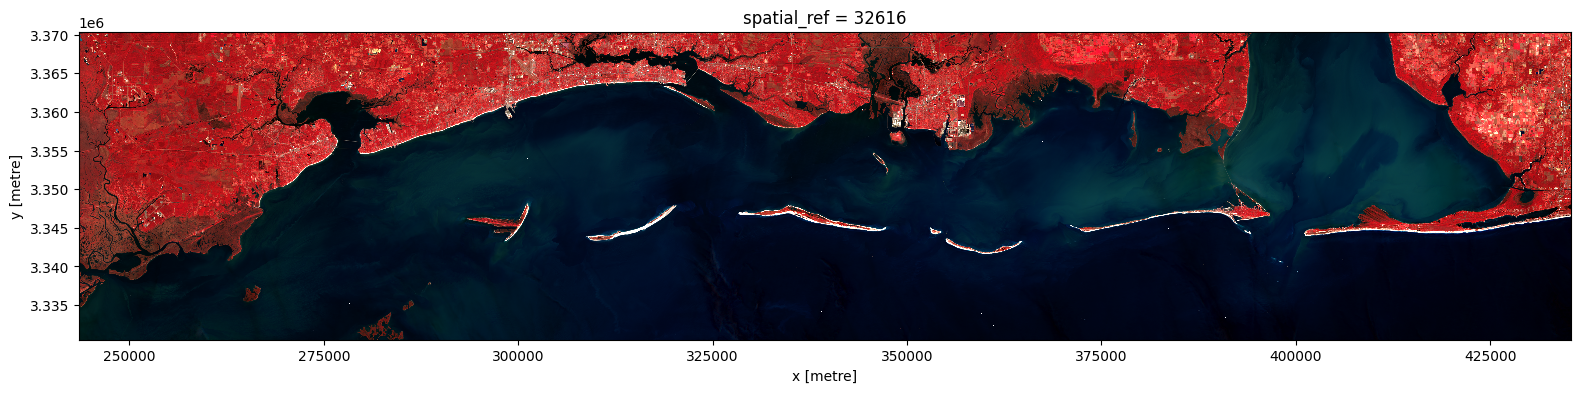

In [4]:
# selected the first timestep
print(pcx.prepare_data.__doc__)

# The input to prepare_data *must* be a GeoDataFrame with a 'geometry' column
selected_s30_items_gdf = s30_items_gdf.iloc[:3].copy()

s2_image = pcx.prepare_data(
    selected_s30_items_gdf,
    geometry=roi_geom,
    crs=utm_16n_crs,
    bands=['B8A', 'B04', 'B03'],  # NIR, Red, Green
    target_resolution=10.0, # Upsample to 10m resolution (just for demonstration purposes),
    merge_method='mean',  # Use the mean of overlapping pixels
    resampling_method='bilinear',  # Resample using bilinear interpolation
    max_workers=-1,  # Use all available CPU cores for parallel processing
)

aspect = s2_image.shape[2] / s2_image.shape[1]  # Calculate aspect ratio based on the image dimensions
s2_image.plot.imshow(size=4, aspect=aspect, vmin=0, vmax=3000)

Occasionally, it may be valuable to look at the extent of each item in the collection to see how they overlap with the geometry of interest. As the results of the query are returned as a GeoDataFrame, this can be accomplished using the `plot` method from GeoPandas.

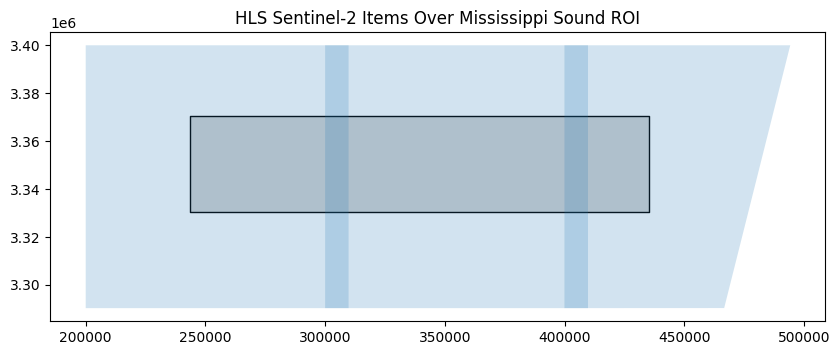

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

ms_sound_gdf.plot(ax=ax, color='lightgray', edgecolor='black')
selected_s30_items_gdf.plot(ax=ax, alpha=0.2)

ax.set_title("HLS Sentinel-2 Items Over Mississippi Sound ROI")
plt.show()

### An addendum - `query_and_prepare`

In addition to the `pcx.prepare_data` function, `pcxarray` also provides a convenience function called `pcx.query_and_prepare`. This function combines the querying and preparation steps into a single function call, which can be useful for quickly getting started with a new dataset. The usage is similar to `pcx.prepare_data`, but it takes the collection ID and datetime range as additional arguments.

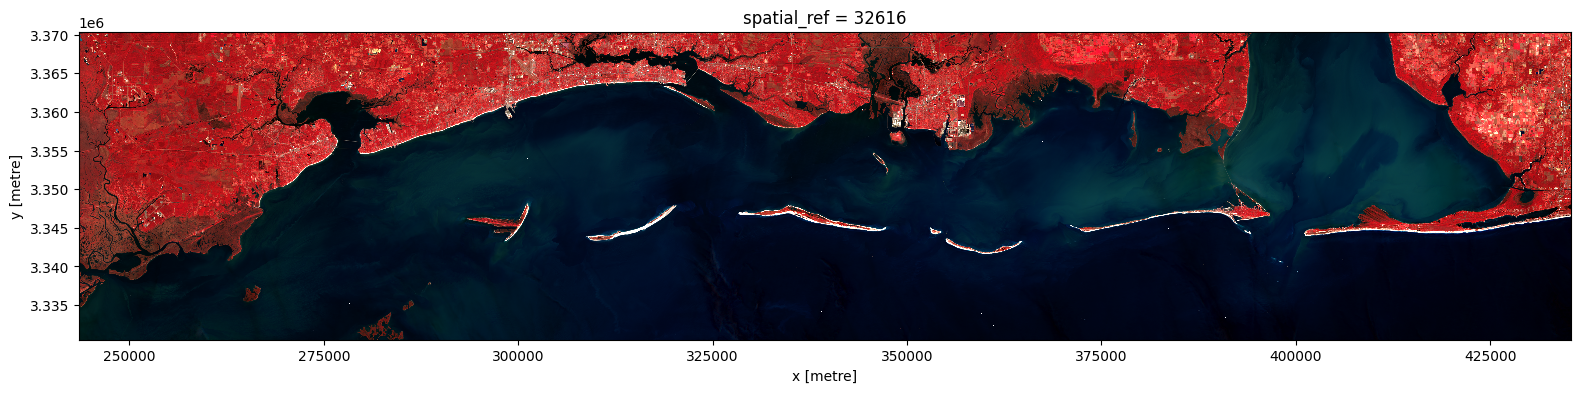

In [6]:
s2_image = pcx.query_and_prepare(
    collections=hls_sentinel_collection_id,
    geometry=roi_geom,
    datetime='2024-01-02',
    crs=utm_16n_crs,
    bands=['B8A', 'B04', 'B03'],  # NIR, Red, Green
    target_resolution=10.0,  # Upsample to 10m resolution (just for demonstration purposes),
    merge_method='mean',  # Use the mean of overlapping pixels
    resampling_method='bilinear',  # Resample using bilinear interpolation
    max_workers=-1,  # Use all available CPU cores for parallel processing
)

# Output should be the same as above
aspect = s2_image.shape[2] / s2_image.shape[1] 
s2_image.plot.imshow(size=4, aspect=aspect, vmin=0, vmax=3000)

## Preparing a timeseries

For satellite data in particular, preparing a timeseries of reflectance values is a common task. `pcxarray` provides a convenient function for this called `pcx.prepare_timeseries`, which wraps around the `pcx.prepare_data` function to handle multiple items in a GeoDataFrame and return a single xarray DataArray containing the timeseries of reflectance values for each band. This function can be used to prepare a timeseries of data for a given geometry, CRS, and list of bands based on the items provided in a GeoDataFrame.

By default, individual timesteps are processed on a per-date basis, meaning that if multiple items are available for a given date, they will be mosaicked together using the specified mosaicking method (though this functionality can be disabled using `ignore_time_component=True` if not necessary). Like `pcx.prepare_data`, `pcx.prepare_timeseries` can be supplied with optional arguments to adjust the resampling method, mosaicking method, desired resolution, chunking behavior, multiprocessing, and more.

Due to the often large size of timeseries datasets, it is highly recommended to use the `chunks` argument to specify how the data should be chunked for processing. Due to how `pcxarray` works, chunking is best supported along the `x` and `y` dimensions of a DataArray (chunking along `band` ), so the best way to handle chunking is to provide a dictionary with the keys `x` and `y` and the desired chunk sizes in each dimension. For most cases over relatively small geometries or for relatively coarse data, using `chunks={'x': -1, 'y': -1}` is sufficient, which will chunk the data into a single chunk along the spatial dimensions. Playing around with the chunk sizes can have a performance impact, so it may be worth experimenting with different chunk sizes to find the best performance for a specific use case. Chunking along the `time` or `band` dimensions is supported, but will either trigger a rechunking operation or will add an additional rechunking node to the Dask computation graph, which can lead to increased memory usage or slower performance in certain cases.

Further, to take advantage of Dask's parallel processing capabilities, using a Dask local cluster is also recommended. Information on how to install and use the Dask distributed scheduler can be found in the [Dask documentation](https://docs.dask.org/en/stable/deploying-python.html). A minimal example is shown below, which is sufficient for most use cases.


In [ ]:
from distributed import Client

client = Client()
print(f"Dask client dashboard: {client.dashboard_link}")

Dask client dashboard: http://127.0.0.1:8787/status


2025-07-09 12:26:06,461 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 4380a1203b5ddc4bcf0bbee0868a1a79 initialized by task ('rechunk-merge-rechunk-transfer-c10d8b53cbf32c886cfb4dee50bb17de', 0, 0, 0, 0, 0, 70) executed on worker tcp://127.0.0.1:42233


In [8]:
s30_da = pcx.prepare_timeseries(
    items_gdf=s30_items_gdf,
    bands=["B03", "B04", "Fmask"],
    geometry=roi_geom,
    crs=utm_16n_crs,
    chunks={"x": -1, "y": -1},  # specify chunk size for dask
    max_workers=-1,  # use all available workers
)
display(s30_da)

l30_da = pcx.prepare_timeseries(
    items_gdf=l30_items_gdf,
    bands=["B03", "B04", "Fmask"],
    geometry=roi_geom,
    crs=utm_16n_crs,
    chunks={"x": -1, "y": -1},
    max_workers=-1,
)
display(l30_da)

Constructing dask computation graph: 100%|██████████| 166/166 [00:58<00:00,  2.83timestep/s]


<xarray.DataArray 'reproject-49281c8cd10048a18b98ef04c4c9c666' (time: 166,
                                                                band: 3,
                                                                y: 1330, x: 6399)> Size: 17GB
dask.array<getitem, shape=(166, 3, 1330, 6399), dtype=float32, chunksize=(1, 1, 1330, 6399), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1kB 2024-01-02 2024-01-04 ... 2024-12-30
  * band         (band) <U5 60B 'B03' 'B04' 'Fmask'
  * y            (y) float64 11kB 3.37e+06 3.37e+06 ... 3.331e+06 3.331e+06
  * x            (x) float64 51kB 2.435e+05 2.435e+05 ... 4.354e+05 4.354e+05
    spatial_ref  int32 4B 32616
Attributes: (12/42)
    ACCODE:                                            LaSRC
    add_offset:                                        0.0
    arop_ave_xshift(meters):                           0
    arop_ave_yshift(meters):                           0
    arop_ncp:                                          0
    arop_rmse(meters):                                 0
    ...                                                ...
    SPATIAL_RESOLUTION:                                30
    TILE_ID:                                           S2A_OPER_MSI_L1C_TL_2A...
    ULX:                                               399960
    ULY:                                               3400020
    AREA_OR_POINT:                                     Area
    _FillValue:                                        nan

Constructing dask computation graph: 100%|██████████| 113/113 [00:39<00:00,  2.85timestep/s]


<xarray.DataArray 'reproject-ae055f28c2f24c7aa9c48cfc4438fdf5' (time: 113,
                                                                band: 3,
                                                                y: 1330, x: 6399)> Size: 12GB
dask.array<getitem, shape=(113, 3, 1330, 6399), dtype=float32, chunksize=(1, 1, 1330, 6399), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 904B 2024-01-01 2024-01-07 ... 2024-12-25
  * band         (band) <U5 60B 'B03' 'B04' 'Fmask'
  * y            (y) float64 11kB 3.37e+06 3.37e+06 ... 3.331e+06 3.331e+06
  * x            (x) float64 51kB 2.435e+05 2.435e+05 ... 4.354e+05 4.354e+05
    spatial_ref  int32 4B 32616
Attributes: (12/36)
    ACCODE:                    Lasrc
    add_offset:                0.0
    arop_ave_xshift(meters):   0
    arop_ave_yshift(meters):   0
    arop_ncp:                  0
    arop_rmse(meters):         0
    ...                        ...
    TIRS_SSM_POSITION_STATUS:  ESTIMATED
    ULX:                       300000
    ULY:                       3400020
    USGS_SOFTWARE:             LPGS_16.3.1
    AREA_OR_POINT:             Area
    _FillValue:                nan

### Dask lazy execution model

Both of the operations above should run relatively quickly, as they they are only preparing the Dask computation graphs which involves reading a small amount of metadata from the rasters and creating the necessary Dask arrays, but not actually downloading or processing any data yet. The actual data loading and processing will occur when the Dask computation graph is executed, which can be done at a later time (e.g., by using the `compute()` method on the resulting DataArray instance).

Full compatibility with Dask's lazy execution model is a key priority for `pcxarray` and is one of the main reasons it was created. Unlike most other geospatial libraries that rely on GDAL for data accesss (and thus breaks Dask's lazy execution model), `pcxarray` utilizes `odc-geo` to handle reprojection and mosaicking of rasters instead, ensuring that the Dask computation graph is not evaluated until it is expliciltly requested. This approach allows a user to define a complex processing pipeline where a large dataset undergoes multiple transformations, but does not necessarily require the data to be loaded into memory all at once, rather, it will be loaded in chunks as needed when the computation is executed and discarded once the raw data is no longer needed to produce the final result. For more information on Dask, see the [Dask documentation](https://docs.dask.org/en/stable/).

Now that both timeseries DataArrays have been prepared, they can be concatenated together to create a single DataArray containing both the harmonized Sentinel-2 and Landsat timeseries. While not strictly necessary here, it is good practice to rename the band values to ensure they are consistent with each other before concatenating the arrays. For example, the Sentinel-2 band name for the NIR Narrow band is "B8A", while Landsat uses "B05" to refer to the same spectral band. To ensure consistency and make things easier, renaming the bands to a common, more descriptive name is recommended.

In [9]:
import xarray as xr

s30_bands_mapping = {
    'B03': 'green',
    'B04': 'red',
    'Fmask': 'fmask'
}
l30_bands_mapping = {
    'B03': 'green',
    'B04': 'red',
    'Fmask': 'fmask'
}

# rename the bands in the data arrays
s30_da = s30_da.assign_coords(band=[s30_bands_mapping[b] for b in s30_da.band.values])
l30_da = l30_da.assign_coords(band=[l30_bands_mapping[b] for b in l30_da.band.values])

da = xr.concat([s30_da, l30_da], dim='time')
da = da.sortby('time')  # sort by time to ensure chronological order
display(da)

<xarray.DataArray 'reproject-49281c8cd10048a18b98ef04c4c9c666' (time: 279,
                                                                band: 3,
                                                                y: 1330, x: 6399)> Size: 28GB
dask.array<getitem, shape=(279, 3, 1330, 6399), dtype=float32, chunksize=(1, 1, 1330, 6399), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2kB 2024-01-01 2024-01-02 ... 2024-12-30
  * y            (y) float64 11kB 3.37e+06 3.37e+06 ... 3.331e+06 3.331e+06
  * x            (x) float64 51kB 2.435e+05 2.435e+05 ... 4.354e+05 4.354e+05
    spatial_ref  int32 4B 32616
  * band         (band) <U5 60B 'green' 'red' 'fmask'
Attributes: (12/42)
    ACCODE:                                            LaSRC
    add_offset:                                        0.0
    arop_ave_xshift(meters):                           0
    arop_ave_yshift(meters):                           0
    arop_ncp:                                          0
    arop_rmse(meters):                                 0
    ...                                                ...
    SPATIAL_RESOLUTION:                                30
    TILE_ID:                                           S2A_OPER_MSI_L1C_TL_2A...
    ULX:                                               399960
    ULY:                                               3400020
    AREA_OR_POINT:                                     Area
    _FillValue:                                        nan

## Data processing

Now that the raw reflectance values have been concatenated into a single DataArray, the next step is to process the data to extract the desired information. The processsing pipeline defined here does the following:

1. Mask out all pixels that are either not water or are obstructed by clouds, cloud shadows, or snow/ice using the Fmask QA band.
2. Calculate the Normalized Difference Turbidity Index (NDTI) using the red and green bands (see https://doi.org/10.1016/j.rse.2006.07.012).
3. Remove NDTI outliers.
4. Calculate the weekly mean NDTI values for each pixel.
5. Interpolate the weekly mean NDTI values to fill in gaps smaller than 6 weeks using [PCHIP](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html).

In [10]:
# use fmask to mask out invalid data according to the following criteria:
# Water: Yes (bit 5 == 1)
# Snow/Ice: No (bit 4 == 0)
# Cloud shadow: No (bit 3 == 0)
# Adjacent to cloud/shadow: No (bit 2 == 0)
# Cloud: No (bit 1 == 0)
# For more information on the HLS QA layer, see https://lpdaac.usgs.gov/documents/1698/HLS_User_Guide_V2.pdf

fmask = da.sel(band='fmask')
fmask = fmask.where(fmask.notnull(), 0)  # replace NaNs with 0 for masking
fmask = fmask.astype(int)  # ensure fmask is of integer type for bitwise operations

water_mask              = fmask & 0b00100000 == 0b00100000 # bit 5 is set for water
snow_mask               = fmask & 0b00010000 == 0b00010000 # bit 4 is set for snow/ice 
cloud_shadow_mask       = fmask & 0b00001000 == 0b00001000 # bit 3 is set for cloud shadow
cloud_mask              = fmask & 0b00000010 == 0b00000010 # bit 1 is set for cloud

valid_data_mask = water_mask & ~(snow_mask | cloud_shadow_mask | cloud_mask)
da = da.where(valid_data_mask)

def calculate_ndti(da):
    red = da.sel(band='red') / 10000
    green = da.sel(band='green') / 10000
    
    ndti = (red - green) / (red + green + 1e-10)  # Adding a small constant to avoid division by zero
    ndti = ndti.clip(min=-1, max=1)  # Clip values to the range [-1, 1]
    return ndti

ndti = calculate_ndti(da)

# remove outliers in the NDTI data
q95_ndti = ndti.quantile(0.95, dim='time')
q05_ndti = ndti.quantile(0.05, dim='time')
ndti = ndti.where((ndti <= q95_ndti) & (ndti >= q05_ndti))

# resample the NDTI data to weekly intervals and interpolate missing values
weekly_ndti = ndti.resample(time='1W').mean()
weekly_ndti = weekly_ndti.chunk({'time': -1}) # need to rechunk along the time dimension for interpolation
weekly_ndti = weekly_ndti.interpolate_na(dim='time', method='pchip', max_gap='6W') # Interpolate missing values 

# Now, persist the weekly_ndti prior to visualization or further processing
weekly_ndti = weekly_ndti.persist()

/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/dask/array/core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 81
  result = blockwise(
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/dask/array/core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 81
  result = blockwise(
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 20.86 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


## Plotting the results

Once `.persist()` is called on the DataArray, the Dask computation graph begins to execute and the data is loaded into memory. As such, visualization and further analysis can be performed on the resulting DataArray as usual.

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from pandas import Timedelta

fig, ax = plt.subplots(figsize=(8, 5))

vmin = weekly_ndti.min().values
vmax = weekly_ndti.max().values

def update(frame):
    ax.clear()
    weekly_ndti.isel(time=frame).plot.imshow(
        ax=ax, add_colorbar=False, cmap='RdYlBu_r', vmin=vmin, vmax=vmax
    )

    ax.set_title(None)
    ax.set_aspect('equal')
    ax.axis('off')
    x_lim, ylim = ax.get_xlim(), ax.get_ylim()
    ms_sound_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    
    ax.set_xlim(x_lim)
    ax.set_ylim(ylim)
    
    # fig.suptitle(f"Oktibbeha County, MS Sentinel-2 Mean EVI\n" + \
    fig.suptitle(f"Mississippi Sound, HLS Weekly NDTI Estimates\n" + \
        f"{weekly_ndti['time'][frame].dt.strftime('%b %d').values} - " + \
        f"{(weekly_ndti['time'][frame] + Timedelta(days=6)).dt.strftime('%b %d, %Y').values}")
    
init_plot = weekly_ndti.isel(time=0).plot.imshow(
    ax=ax, add_colorbar=True, cbar_kwargs={'label': 'NDTI'}, cmap='RdYlBu_r', vmin=vmin, vmax=vmax
)

ani = FuncAnimation(fig, update, frames=len(weekly_ndti['time']), repeat=False)

# show in notebook
HTML(ani.to_jshtml(fps=1, default_mode='once')) 


/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will